In [2]:
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
import numpy as np
import pandas as pd
import time
import plotly.graph_objects as go
import swifter
from sklearn.decomposition import PCA
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
import datetime as dt
from prettytable import PrettyTable
import math
import plotly.express as px
from plotly.subplots import make_subplots
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.neighbors import NearestNeighbors, LocalOutlierFactor
from sklearn.preprocessing import normalize, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split, PredefinedSplit
from sklearn.metrics import classification_report, roc_curve, confusion_matrix, auc
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
import import_ipynb
import warnings

In [3]:
warnings.filterwarnings("ignore")
np.random.seed(seed=42)

In [86]:
class LogisticClassifier():
    '''
    Initialize LogisticClassifier.
    The DataFrame required consists in column features except for the last column which is the labels.
    '''
    def __init__(self, Xtrain, Xvalidate, Xtest, ytrain, yvalidate, ytest, mute= False, scale = True, balancing= 'weighting'):
        print("-"*60)
        print(f"Initializing Logitic Regression Classifier")
        self.df = df
        self.Xtrain = Xtrain
        self.ytrain = ytrain
        self.Xvalidate = Xvalidate
        self.yvalidate = yvalidate
        self.Xtest = Xtest
        self.ytest = ytest
        self.mute = mute
        self.scale = scale
        self.balancing = balancing
        
        if balancing == "weighting":
            class_wheights= ['balanced']
        else:
            class_wheights = [None]
        
        self.param_grid_train = {'solver': ['liblinear','saga'], 
        'class_weight' : class_wheights,
        'max_iter': [100, 1000]}

        self.param_grid_val = {'penalty': ['l1', 'l2', 'elasticnet'],
        'C':np.logspace(-3, 3, 5)}

        start_time = time.time()
        # Preprocess data
        self.Xtrain_val , self.ytrain_val, self.Xtrain,self.ytrain, self.Xtest = self.preprocess()

        # Build Model
        self.base_model = LogisticRegression(n_jobs=-1)

        self.grid_search()
         
        self.predict(self.Xtest)
        
        self.show_coefficients()
        
        self.roc_curve()
        
        end_time = time.time()
        print(f"Time Elapsed:{end_time - start_time}")
        
        
    def preprocess(self):
        print("-"*60)
        print(f"Preprocessing in progress...")
        
        #Resampling the dataset using Smote-Algorithm
        if self.balancing == 'SMOTE':
            sm = SMOTE(random_state = 42, n_jobs=-1)
            Xtrain, ytrain = sm.fit_resample(self.Xtrain, self.ytrain)
            
        else:
            ytrain = self.ytrain
            Xtrain = self.Xtrain
            
        # Concatenating Training and Validation set to comply with Sklearn's structure
        X_train_val = pd.concat([Xtrain,self.Xvalidate])
        y_train_val = np.concatenate((ytrain, self.yvalidate))
        
        # Scaling the explanatory variables to be between 0 and 1
        if self.scale == True:
            X_train_val = MinMaxScaler().fit_transform(X_train_val)
            X_train_val = pd.DataFrame(X_train_val, columns=self.Xtrain.columns)

            Xtrain = MinMaxScaler().fit_transform(Xtrain)
            Xtrain = pd.DataFrame(Xtrain, columns=self.Xtrain.columns)

            Xtest = MinMaxScaler().fit_transform(self.Xtest)
            Xtest = pd.DataFrame(Xtest, columns=self.Xtest.columns)
        else:
            Xtest = self.Xtest
        


            
        return X_train_val, y_train_val, Xtrain, ytrain, Xtest

    
    def predefined_split(self):
        '''
        Predefines the split of training and validation set to be later used in the grid search
        '''
        n_train = len(self.Xtrain)
        n_val = len(self.Xvalidate)
        
        train_list= [-1] * n_train
        val_list = [0] * n_val
        testfold = train_list + val_list
        ps = PredefinedSplit(test_fold = testfold)
        return ps



    def grid_search(self):
        '''
        Grid Search with params provided, best models get stored in self.model.
        '''
        print("-"*60)
        print("Performing Grid Search...")

        # Base model only learning based on the training sample
        grid = GridSearchCV(self.base_model, self.param_grid_train , scoring='f1', n_jobs=-1)
        self.base_model = grid.fit(self.Xtrain, self.ytrain)
        print('Best base params after grid search', grid.best_params_)
        print('Best base estimators after grid search', grid.best_estimator_)

        # Final model learning on both training and validation sample
        #Transfering parameters and estimator values to model
        self.model = LogisticRegression(solver=grid.best_params_['solver'], class_weight=grid.best_params_['class_weight'],max_iter=grid.best_params_['max_iter'], n_jobs = -1)

        ps = self.predefined_split()
        

        # As classes are imbalanced we try to maximize the f1 score. 
        grid = GridSearchCV(self.model, self.param_grid_val, scoring='f1',cv=ps ,n_jobs=-1)
        self.model = grid.fit(self.Xtrain_val , self.ytrain_val)
        print('Best params after grid search', grid.best_params_)
        self.hyperparameter_heatmap()


    def predict(self, X):
        '''
        Predict and print classification report
        '''
        print("-"*60)
        print('Predicting...')
        self.yfit = self.model.predict(X)
        self.classification_report()

    def classification_report(self):
        '''
        Print Classification Report
        '''
        print("-"*60)
        print('Classification Report')
        print(classification_report(self.ytest, self.yfit, target_names=['Regulars', 'Hits']))
        tn, fp, fn, tp = confusion_matrix(self.ytest,  self.yfit).ravel()
        print(f"TN: {tn}\nFP: {fp}\nFN: {fn}\nTP: {tp}")


    def roc_curve(self):
        fpr, tpr, _ = roc_curve(self.ytest[:], self.yfit[:])
        roc_auc = auc(fpr, tpr)
        
        # Visualization

        plt.plot(fpr, tpr, color='tab:orange',
                lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='tab:blue', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.legend(loc="lower right")
        plt.title('Receiver operating characteristic')
        
    def get_classification_report(self):
        '''
        Returns the classification report
        '''
        measures_info = classification_report(self.ytest, self.yfit, output_dict = True, target_names = ['Regulars', 'Hits'])
        tn, fp, fn, tp = confusion_matrix(self.ytest,  self.yfit).ravel()
        fpr, tpr, _ = roc_curve(self.ytest[:], self.yfit[:])
        roc_auc = auc(fpr, tpr)
        measures_info["Overall"] = {"TN": tp, "FP": fp, "FN": fn, "TP": tp, "AUC": roc_auc}
        
        return measures_info


    def set_train_grid(self, grid_dict):
        self.param_grid_train = grid_dict


    def set_validation_grid(self, grid_dict):
        self.param_grid_val = grid_dict


    def retrain(self):
        self.base_model = LogisticRegression()

        self.grid_search()
         
        self.predict(self.Xtest)


    def get_coefficients(self, n_classes = 2):
        '''
        This function selects the 'n' most important features by their coefficients for the respective classes of the model
        '''
        #Iterating over all classes
        feature_tab = PrettyTable()
        feature_tab.add_column("Rank",[i+1 for i in range(len(self.Xtrain.columns))])


        #Getting the most important features
        feature_dict = {}
        features = self.model.best_estimator_.coef_[0]
        for feature_number ,coef in enumerate(features):
            feature_dict[self.Xtrain.columns[feature_number]] = coef
        intercept =  self.model.best_estimator_.intercept_[0]
        feature_dict['intercept'] = intercept

        #Transforming the features back to words


        return feature_dict
    
    def show_coefficients(self):
        
        feature_dict = self.get_coefficients()
        feature_tab = PrettyTable()

        feature_tab.field_names = list(feature_dict.keys())
        feature_tab.add_row(list(feature_dict.values()))
        
        fig = go.Figure(go.Bar(
            y=list(feature_dict.keys()),
            x= list(feature_dict.values()),
            orientation='h'))
        fig.update_layout(yaxis={'categoryorder':'total ascending'})
        fig.show()

        print("-"*60)
        print('Coefficients')
        print(feature_tab)
        
    def hyperparameter_heatmap(self):
        
        results = pd.DataFrame(self.model.cv_results_)
        hm_data = results.pivot(index='param_penalty', 
                        columns='param_C',
                        values='mean_test_score')

        # Plot heatmap
        fix, ax = plt.subplots(figsize=(9, 6))

        ax = sns.heatmap(hm_data,
                        annot=True,
                        cmap='RdBu',
                        linecolor='white')

        ax.set_title('Hyperparameter Gridsearch', fontsize=16)
        ax.set_ylabel('Penalty', fontsize=12)
        ax.set_xlabel('C-Parameter', fontsize=12)

        plt.show()
        print("-"*60)

In [5]:
def split_dataset(df, sample=1):
    df = df.sample(int(sample * df.shape[0]))
    train, validate, test = np.split(df.sample(frac=1, random_state=42), [int(.6*len(df)), int(.8*len(df))])

    print(f" Train: {train.shape}\n", f"Validate: {validate.shape}\n", f"Test: {test.shape}\n")

    Xtrain = train.loc[:, df.columns != 'label']

    Xvalidate = validate.loc[:, df.columns != 'label']

    Xtest = test.loc[:, df.columns != 'label']


    ytrain = train.label.values.ravel()

    yvalidate = validate.label.values.ravel()

    ytest = test.label.values.ravel()

    return Xtrain, Xvalidate, Xtest, ytrain, yvalidate, ytest

In [90]:
df = pd.read_csv("Csv/spotify_preprocessed.csv")
Xtrain, Xvalidate, Xtest, ytrain, yvalidate, ytest = split_dataset(df, sample=1)

 Train: (345369, 19)
 Validate: (115123, 19)
 Test: (115123, 19)



### "Raw" Dataset

------------------------------------------------------------
Initializing Logitic Regression Classifier
------------------------------------------------------------
Preprocessing in progress...
------------------------------------------------------------
Performing Grid Search...
Best base params after grid search {'class_weight': 'balanced', 'max_iter': 100, 'solver': 'saga'}
Best base estimators after grid search LogisticRegression(class_weight='balanced', n_jobs=-1, solver='saga')
Best params after grid search {'C': 31.622776601683793, 'penalty': 'l1'}


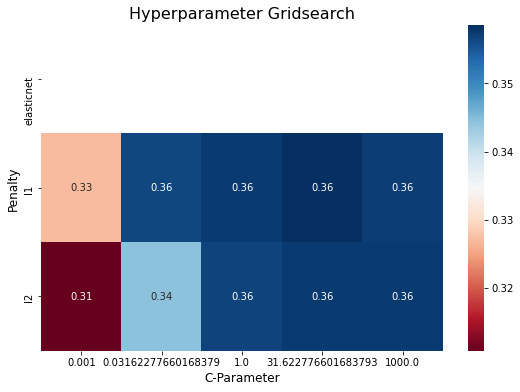

------------------------------------------------------------
------------------------------------------------------------
Predicting...
------------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

    Regulars       0.96      0.76      0.85    103285
        Hits       0.25      0.71      0.37     11838

    accuracy                           0.75    115123
   macro avg       0.60      0.73      0.61    115123
weighted avg       0.89      0.75      0.80    115123

TN: 78090
FP: 25195
FN: 3426
TP: 8412


------------------------------------------------------------
Coefficients
+-------------------+--------------------+-------------------+---------------------+----------------------+-------------------+---------------------+---------------------+-------------------+----------------------+--------------------+---------------------+--------------------+----------------------+-------------------+--------------------+-------------------+--------------------+-------------------+
|    duration_ms    |      explicit      |    danceability   |        energy       |         key          |      loudness     |         mode        |     speechiness     |    acousticness   |   instrumentalness   |      liveness      |       valence       |       tempo        |    time_signature    |      #artists     | combined_followers |   release_month   |    release_day     |     intercept     |
+-------------------+--------------------+-------------------+---------------------+----------------------+-----------

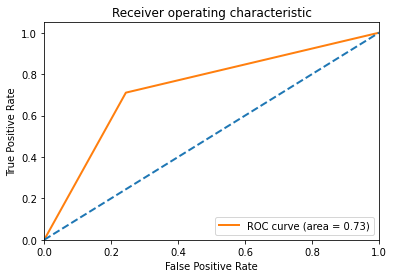

In [93]:
#Scaled - Balancing through Weighting
Lclf = LogisticClassifier(Xtrain, Xvalidate, Xtest, ytrain, yvalidate, ytest)

------------------------------------------------------------
Initializing Logitic Regression Classifier
------------------------------------------------------------
Preprocessing in progress...
------------------------------------------------------------
Performing Grid Search...
Best base params after grid search {'class_weight': None, 'max_iter': 100, 'solver': 'saga'}
Best base estimators after grid search LogisticRegression(n_jobs=-1, solver='saga')
Best params after grid search {'C': 0.03162277660168379, 'penalty': 'l1'}


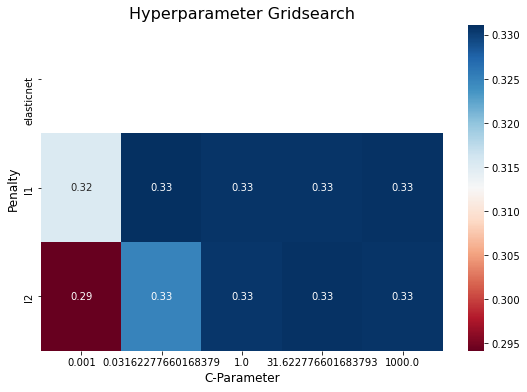

------------------------------------------------------------
------------------------------------------------------------
Predicting...
------------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

    Regulars       0.94      0.81      0.87    103285
        Hits       0.26      0.57      0.36     11838

    accuracy                           0.79    115123
   macro avg       0.60      0.69      0.62    115123
weighted avg       0.87      0.79      0.82    115123

TN: 84107
FP: 19178
FN: 5081
TP: 6757


------------------------------------------------------------
Coefficients
+--------------------+----------------------+--------------------+---------------------+---------------------+-------------------+---------------------+---------------------+---------------------+----------------------+---------------------+---------------------+--------------------+---------------------+--------------------+--------------------+----------------------+--------------------+--------------------+
|    duration_ms     |       explicit       |    danceability    |        energy       |         key         |      loudness     |         mode        |     speechiness     |     acousticness    |   instrumentalness   |       liveness      |       valence       |       tempo        |    time_signature   |      #artists      | combined_followers |    release_month     |    release_day     |     intercept      |
+--------------------+----------------------+--------------------+---------------------+----------

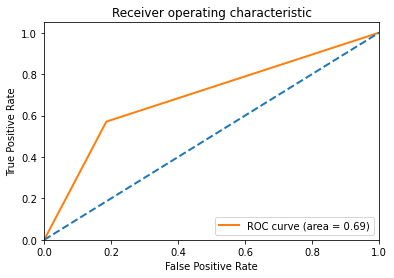

In [94]:
#Scaled - Balancing through SMOTEENN
Lclf_SMOTE = LogisticClassifier(Xtrain, Xvalidate, Xtest, ytrain, yvalidate, ytest, balancing="SMOTE")

------------------------------------------------------------
Initializing Logitic Regression Classifier
------------------------------------------------------------
Preprocessing in progress...
------------------------------------------------------------
Performing Grid Search...
Best base params after grid search {'class_weight': 'balanced', 'max_iter': 100, 'solver': 'liblinear'}
Best base estimators after grid search LogisticRegression(class_weight='balanced', n_jobs=-1, solver='liblinear')
Best params after grid search {'C': 0.001, 'penalty': 'l1'}


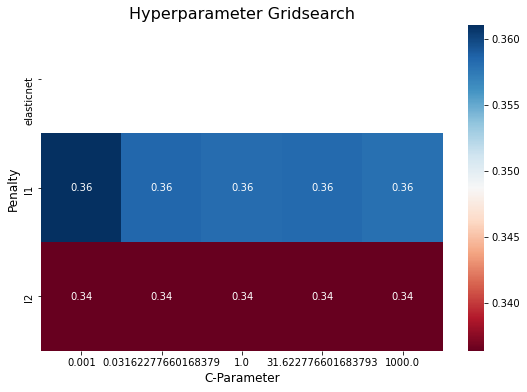

------------------------------------------------------------
------------------------------------------------------------
Predicting...
------------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

    Regulars       0.96      0.76      0.85    103285
        Hits       0.25      0.70      0.37     11838

    accuracy                           0.75    115123
   macro avg       0.60      0.73      0.61    115123
weighted avg       0.88      0.75      0.80    115123

TN: 78526
FP: 24759
FN: 3495
TP: 8343


------------------------------------------------------------
Coefficients
+-----------------------+--------------------+--------------------+--------+----------------------+---------------------+------+---------------------+---------------------+----------------------+---------------------+---------------------+-----------------------+----------------------+---------------------+------------------------+----------------------+---------------------+-----------+
|      duration_ms      |      explicit      |    danceability    | energy |         key          |       loudness      | mode |     speechiness     |     acousticness    |   instrumentalness   |       liveness      |       valence       |         tempo         |    time_signature    |       #artists      |   combined_followers   |    release_month     |     release_day     | intercept |
+-----------------------+--------------------+--------------------+--------+----------------------+---------------------+------+----------------

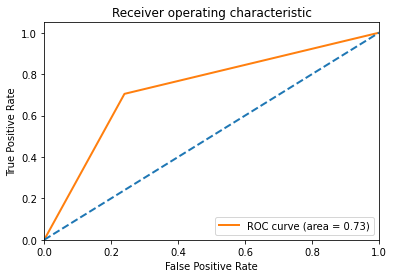

In [95]:
#Unscaled - Balancing through Weighting
Lclf_us = LogisticClassifier(Xtrain, Xvalidate, Xtest, ytrain, yvalidate, ytest, scale= False)

------------------------------------------------------------
Initializing Logitic Regression Classifier
------------------------------------------------------------
Preprocessing in progress...
------------------------------------------------------------
Performing Grid Search...
Best base params after grid search {'class_weight': None, 'max_iter': 100, 'solver': 'liblinear'}
Best base estimators after grid search LogisticRegression(n_jobs=-1, solver='liblinear')
Best params after grid search {'C': 0.001, 'penalty': 'l1'}


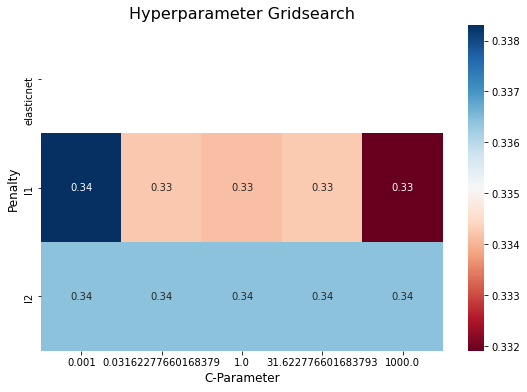

------------------------------------------------------------
------------------------------------------------------------
Predicting...
------------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

    Regulars       0.94      0.82      0.88    103285
        Hits       0.27      0.58      0.37     11838

    accuracy                           0.79    115123
   macro avg       0.61      0.70      0.62    115123
weighted avg       0.87      0.79      0.83    115123

TN: 84665
FP: 18620
FN: 4981
TP: 6857


------------------------------------------------------------
Coefficients
+------------------------+----------+--------------------+--------+----------------------+-------------------+---------------------+----------------------+---------------------+---------------------+---------------------+---------------------+-----------------------+-----------------------+---------------------+------------------------+----------------------+---------------------+---------------------+
|      duration_ms       | explicit |    danceability    | energy |         key          |      loudness     |         mode        |     speechiness      |     acousticness    |   instrumentalness  |       liveness      |       valence       |         tempo         |     time_signature    |       #artists      |   combined_followers   |    release_month     |     release_day     |      intercept      |
+------------------------+----------+--------------------+--------+----------------------+-------------------+----

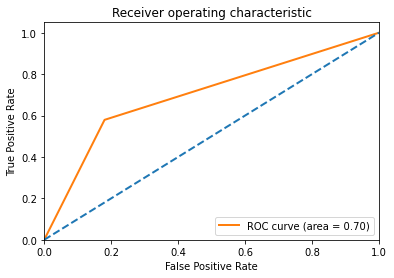

In [96]:
#Unscaled - Balancing through SMOTEENN
Lclf_us_SMOTE = LogisticClassifier(Xtrain, Xvalidate, Xtest, ytrain, yvalidate, ytest, scale= False, balancing="SMOTE")

### Outlier adjusted dataset

In [11]:
from OutlierDetection import OutlierDetection

df

importing Jupyter notebook from OutlierDetection.ipynb


,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,#artists,combined_followers,release_month,release_day,label
0,126903,0,0.645,0.4450,0,-13.338,1,0.4510,0.674,0.744000,0.1510,0.1270,104.851,3,1,91.0,2,22,0
1,98200,0,0.695,0.2630,0,-22.136,1,0.9570,0.797,0.000000,0.1480,0.6550,102.009,1,1,3.0,6,1,0
2,181640,0,0.434,0.1770,1,-21.180,1,0.0512,0.994,0.021800,0.2120,0.4570,130.418,5,1,3528.0,3,21,0
3,176907,0,0.321,0.0946,7,-27.961,1,0.0504,0.995,0.918000,0.1040,0.3970,169.980,3,1,3528.0,3,21,0
4,163080,0,0.402,0.1580,3,-16.900,0,0.0390,0.989,0.130000,0.3110,0.1960,103.220,4,1,11327.0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
575610,258267,0,0.560,0.5180,0,-7.471,0,0.0292,0.785,0.000000,0.0648,0.2110,131.896,4,1,896.0,9,26,0
575611,153293,0,0.765,0.6630,0,-5.223,1,0.0652,0.141,0.000297,0.0924,0.6860,150.091,4,1,245944.0,10,21,1
575612,187601,0,0.535,0.3140,7,-12.823,0,0.0408,0.895,0.000150,0.0874,0.0663,145.095,4,1,1168213.0,9,2,1
575613,142003,0,0.696,0.6150,10,-6.212,1,0.0345,0.206,0.000003,0.3050,0.4380,90.029,4,2,116451.5,3,5,1


In [97]:
Xtrain_joined = Xtrain[:]
Xtrain_joined["label"] = ytrain
Xtrain_joined = Xtrain_joined.reset_index()
Xtrain_joined = Xtrain_joined.drop(Xtrain_joined.columns[0], axis=1)

In [98]:
explanatory_variables = Xtrain_joined.columns.drop(['label', "key",'explicit'])

##### Global Outlier

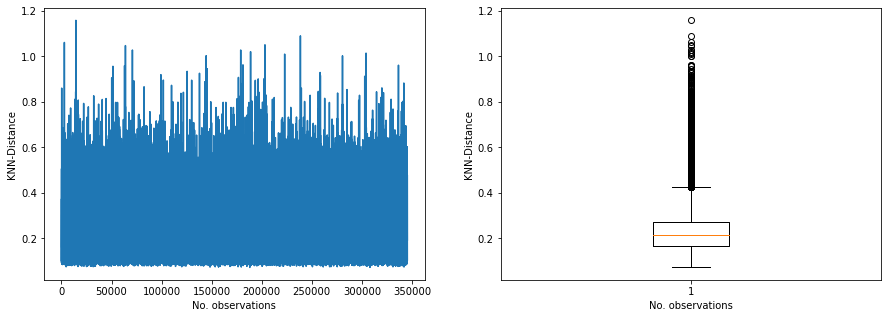

In [14]:
knn_distance = OutlierDetection.knn(Xtrain_joined ,explanatory_variables,k=50)

In [99]:
iqr_summary = OutlierDetection.iqr_summary(pd.DataFrame(knn_distance,  columns=["KNN-Distance"]),[])
iqr_summary

,KNN-Distance
Ratio Upper-Outlier,0.020000
Ratio Lower-Outlier,0.000000
Ratio Total Outlier,0.020000
Upper Bound,0.426006
Lower Bound,0.007256


8215


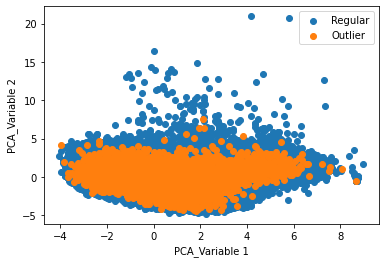

In [100]:
global_outlier_index = OutlierDetection.visualize_knn_outliers(Xtrain_joined, explanatory_variables ,knn_distance, iqr_summary["KNN-Distance"]["Upper Bound"])
print(len(global_outlier_index[0]))

#### Local Outlier

In [17]:
#lof,local_outlier_index = OutlierDetection.lof(df,explanatory_variables, n = 1000)

##### Remove Outliers

In [101]:
global_outlier_index= global_outlier_index[0].tolist()

In [102]:
df_or = OutlierDetection.remove_outliers(Xtrain_joined,global_outlier_index)
Xtrain_or = df_or.loc[:, df_or.columns != 'label']
ytrain_or = df_or["label"]
#Xtrain_or=Xtrain_or.drop(Xtrain_or.columns[0], axis=1)

In [20]:
#Xtrain_or, Xvalidate_or, Xtest_or, ytrain_or, yvalidate_or, ytest_or = split_dataset(df_or, sample=1)

##### Predict

------------------------------------------------------------
Initializing Logitic Regression Classifier
------------------------------------------------------------
Preprocessing in progress...
------------------------------------------------------------
Performing Grid Search...
Best base params after grid search {'class_weight': 'balanced', 'max_iter': 1000, 'solver': 'saga'}
Best base estimators after grid search LogisticRegression(class_weight='balanced', max_iter=1000, n_jobs=-1,
                   solver='saga')
Best params after grid search {'C': 1.0, 'penalty': 'l1'}


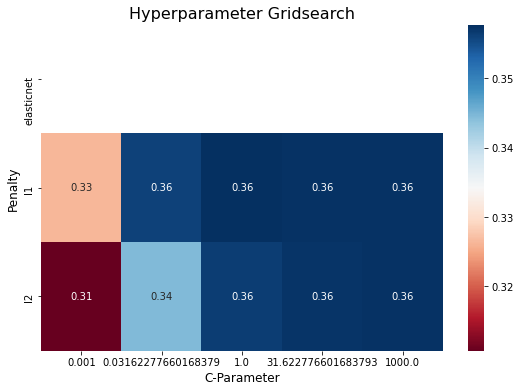

------------------------------------------------------------
------------------------------------------------------------
Predicting...
------------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

    Regulars       0.96      0.76      0.84    103285
        Hits       0.25      0.71      0.37     11838

    accuracy                           0.75    115123
   macro avg       0.60      0.73      0.61    115123
weighted avg       0.89      0.75      0.80    115123

TN: 78004
FP: 25281
FN: 3416
TP: 8422


------------------------------------------------------------
Coefficients
+--------------------+--------------------+-------------------+---------------------+---------------------+--------------------+---------------------+---------------------+---------------------+----------------------+---------------------+---------------------+--------------------+---------------------+-------------------+--------------------+--------------------+--------------------+---------------------+
|    duration_ms     |      explicit      |    danceability   |        energy       |         key         |      loudness      |         mode        |     speechiness     |     acousticness    |   instrumentalness   |       liveness      |       valence       |       tempo        |    time_signature   |      #artists     | combined_followers |   release_month    |    release_day     |      intercept      |
+--------------------+--------------------+-------------------+---------------------+---------------------

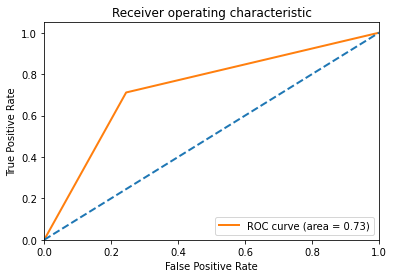

In [103]:
#Scaled - Balancing through weighting
Lclf_or = LogisticClassifier(Xtrain_or, Xvalidate, Xtest, ytrain_or, yvalidate, ytest)

------------------------------------------------------------
Initializing Logitic Regression Classifier
------------------------------------------------------------
Preprocessing in progress...
------------------------------------------------------------
Performing Grid Search...
Best base params after grid search {'class_weight': None, 'max_iter': 100, 'solver': 'saga'}
Best base estimators after grid search LogisticRegression(n_jobs=-1, solver='saga')
Best params after grid search {'C': 0.03162277660168379, 'penalty': 'l1'}


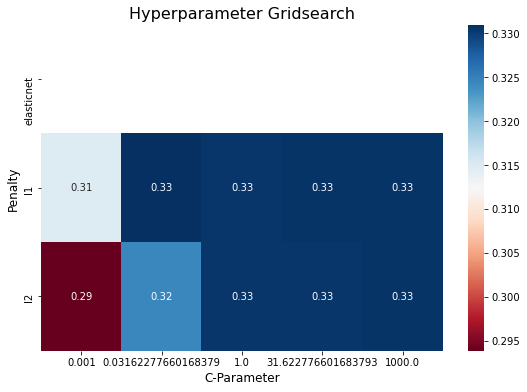

------------------------------------------------------------
------------------------------------------------------------
Predicting...
------------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

    Regulars       0.94      0.82      0.87    103285
        Hits       0.26      0.57      0.36     11838

    accuracy                           0.79    115123
   macro avg       0.60      0.69      0.62    115123
weighted avg       0.87      0.79      0.82    115123

TN: 84292
FP: 18993
FN: 5123
TP: 6715


------------------------------------------------------------
Coefficients
+--------------------+----------------------+--------------------+---------------------+---------------------+-----------------+---------------------+---------------------+---------------------+----------------------+---------------------+---------------------+--------------------+---------------------+--------------------+--------------------+----------------------+--------------------+--------------------+
|    duration_ms     |       explicit       |    danceability    |        energy       |         key         |     loudness    |         mode        |     speechiness     |     acousticness    |   instrumentalness   |       liveness      |       valence       |       tempo        |    time_signature   |      #artists      | combined_followers |    release_month     |    release_day     |     intercept      |
+--------------------+----------------------+--------------------+---------------------+--------------

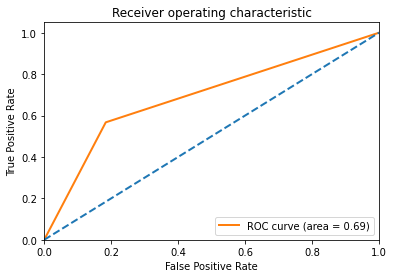

In [104]:
#Scaled - Balancing through Smote
Lclf_or_SMOTE = LogisticClassifier(Xtrain_or, Xvalidate, Xtest, ytrain_or, yvalidate, ytest, balancing="SMOTE")

------------------------------------------------------------
Initializing Logitic Regression Classifier
------------------------------------------------------------
Preprocessing in progress...
------------------------------------------------------------
Performing Grid Search...
Best base params after grid search {'class_weight': 'balanced', 'max_iter': 100, 'solver': 'saga'}
Best base estimators after grid search LogisticRegression(class_weight='balanced', n_jobs=-1, solver='saga')
Best params after grid search {'C': 0.03162277660168379, 'penalty': 'l1'}


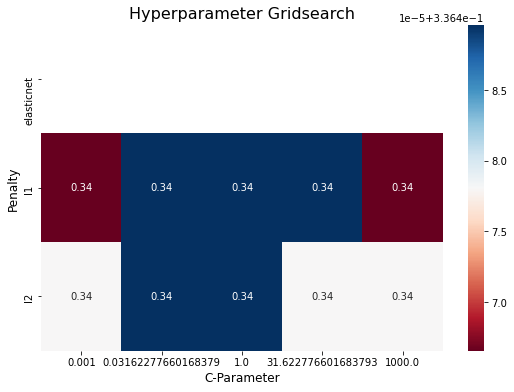

------------------------------------------------------------
------------------------------------------------------------
Predicting...
------------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

    Regulars       0.93      0.87      0.90    103285
        Hits       0.28      0.44      0.35     11838

    accuracy                           0.83    115123
   macro avg       0.61      0.66      0.62    115123
weighted avg       0.87      0.83      0.84    115123

TN: 90078
FP: 13207
FN: 6599
TP: 5239


------------------------------------------------------------
Coefficients
+-------------------------+------------------------+----------------------+------------------------+------------------------+-----------------------+------------------------+------------------------+-------------------------+------------------------+-------------------------+-------------------------+------------------------+------------------------+-------------------------+------------------------+------------------------+----------------------+-------------------------+
|       duration_ms       |        explicit        |     danceability     |         energy         |          key           |        loudness       |          mode          |      speechiness       |       acousticness      |    instrumentalness    |         liveness        |         valence         |         tempo          |     time_signature     |         #artists        |   combined_followers   |     release_month      |     release_day    

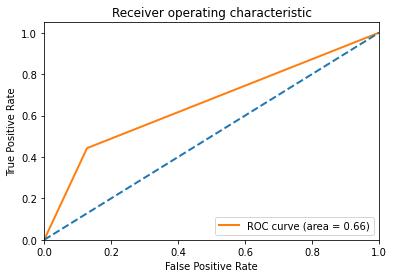

In [105]:
#Uscaled - Balancing through weighting
Lclf_or_us = LogisticClassifier(Xtrain_or, Xvalidate, Xtest, ytrain_or, yvalidate, ytest, scale=False)

------------------------------------------------------------
Initializing Logitic Regression Classifier
------------------------------------------------------------
Preprocessing in progress...
------------------------------------------------------------
Performing Grid Search...
Best base params after grid search {'class_weight': None, 'max_iter': 100, 'solver': 'liblinear'}
Best base estimators after grid search LogisticRegression(n_jobs=-1, solver='liblinear')
Best params after grid search {'C': 0.001, 'penalty': 'l1'}


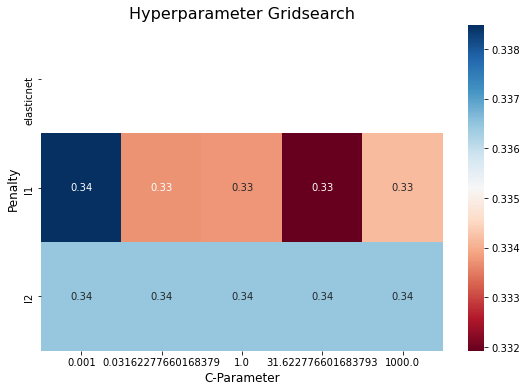

------------------------------------------------------------
------------------------------------------------------------
Predicting...
------------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

    Regulars       0.94      0.82      0.88    103285
        Hits       0.27      0.58      0.37     11838

    accuracy                           0.80    115123
   macro avg       0.61      0.70      0.62    115123
weighted avg       0.87      0.80      0.83    115123

TN: 84846
FP: 18439
FN: 5011
TP: 6827


------------------------------------------------------------
Coefficients
+------------------------+----------+--------------------+--------+---------------------+-------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+----------------------+----------------------+----------------------+-----------------------+-----------------------+---------------------+--------------------+
|      duration_ms       | explicit |    danceability    | energy |         key         |      loudness     |         mode        |     speechiness     |     acousticness    |   instrumentalness  |       liveness      |       valence       |        tempo         |    time_signature    |       #artists       |   combined_followers  |     release_month     |     release_day     |     intercept      |
+------------------------+----------+--------------------+--------+---------------------+-------------------+-------------

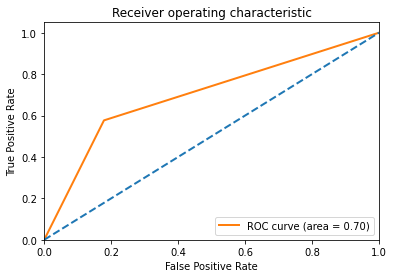

In [106]:
#Uscaled - Balancing through Smote
Lclf_or_us_SMOTE = LogisticClassifier(Xtrain_or, Xvalidate, Xtest, ytrain_or, yvalidate, ytest,scale=False, balancing="SMOTE")

### PCA - Dataset

In [107]:
df_pca = pd.read_csv("Csv/spotify_pca.csv")
df_pca = df_pca.drop(df_pca.columns[0], axis=1)
df_pca['label'] = df['label']

In [108]:
def split_pca(df, sample=1):
    df = df.sample(int(sample * df.shape[0]))
    Xtrain, Xvalidate, Xtest = np.split(df.sample(frac=1, random_state=42), [int(.6*len(df)), int(.8*len(df))])

    print(f" Train: {Xtrain.shape}\n", f"Validate: {Xvalidate.shape}\n", f"Test: {Xtest.shape}\n")

    return Xtrain, Xvalidate, Xtest

In [109]:
Xtrain_pca, Xvalidate_pca, Xtest_pca,ytrain_pca, yvalidate_pca, ytest_pca = split_dataset(df_pca, sample=1)

 Train: (345369, 17)
 Validate: (115123, 17)
 Test: (115123, 17)



------------------------------------------------------------
Initializing Logitic Regression Classifier
------------------------------------------------------------
Preprocessing in progress...
------------------------------------------------------------
Performing Grid Search...
Best base params after grid search {'class_weight': 'balanced', 'max_iter': 100, 'solver': 'saga'}
Best base estimators after grid search LogisticRegression(class_weight='balanced', n_jobs=-1, solver='saga')
Best params after grid search {'C': 1000.0, 'penalty': 'l1'}


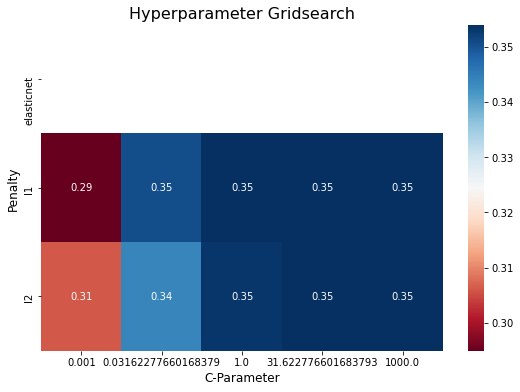

------------------------------------------------------------
------------------------------------------------------------
Predicting...
------------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

    Regulars       0.99      0.20      0.33    103530
        Hits       0.12      0.98      0.21     11593

    accuracy                           0.28    115123
   macro avg       0.55      0.59      0.27    115123
weighted avg       0.90      0.28      0.32    115123

TN: 20761
FP: 82769
FN: 267
TP: 11326


------------------------------------------------------------
Coefficients
+--------------------+--------------------+--------------------+-------------------+------------------+-------------------+---------------------+--------------------+-------------------+---------------------+--------------------+-------------------+---------------------+--------------------+-------------------+--------------------+--------------------+
|         0          |         1          |         2          |         3         |        4         |         5         |          6          |         7          |         8         |          9          |         10         |         11        |          12         |         13         |         14        |         15         |     intercept      |
+--------------------+--------------------+--------------------+-------------------+------------------+-------------------+---------------------+--------------------+-------------------+---------------------+--------

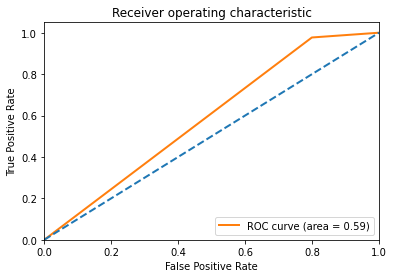

In [110]:
#Scaled - Balancing through wheighting
Lclf_pca = LogisticClassifier(Xtrain_pca, Xvalidate_pca, Xtest_pca, ytrain_pca, yvalidate_pca, ytest_pca )

------------------------------------------------------------
Initializing Logitic Regression Classifier
------------------------------------------------------------
Preprocessing in progress...
------------------------------------------------------------
Performing Grid Search...
Best base params after grid search {'class_weight': None, 'max_iter': 100, 'solver': 'saga'}
Best base estimators after grid search LogisticRegression(n_jobs=-1, solver='saga')
Best params after grid search {'C': 1000.0, 'penalty': 'l2'}


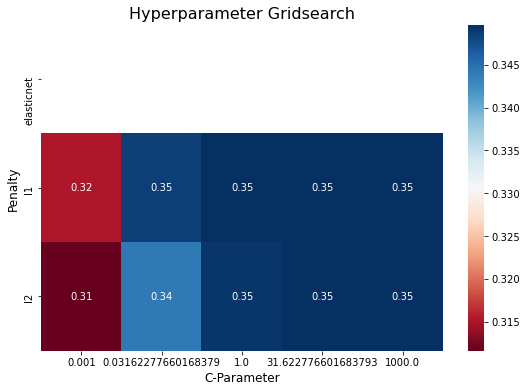

------------------------------------------------------------
------------------------------------------------------------
Predicting...
------------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

    Regulars       0.98      0.25      0.40    103530
        Hits       0.13      0.96      0.22     11593

    accuracy                           0.32    115123
   macro avg       0.55      0.60      0.31    115123
weighted avg       0.90      0.32      0.38    115123

TN: 25650
FP: 77880
FN: 462
TP: 11131


------------------------------------------------------------
Coefficients
+--------------------+--------------------+---------------------+--------------------+-------------------+-------------------+---------------------+--------------------+-------------------+---------------------+--------------------+--------------------+---------------------+--------------------+---------------------+--------------------+---------------------+
|         0          |         1          |          2          |         3          |         4         |         5         |          6          |         7          |         8         |          9          |         10         |         11         |          12         |         13         |          14         |         15         |      intercept      |
+--------------------+--------------------+---------------------+--------------------+-------------------+-------------------+---------------------+--------------------+-------------------+-------------

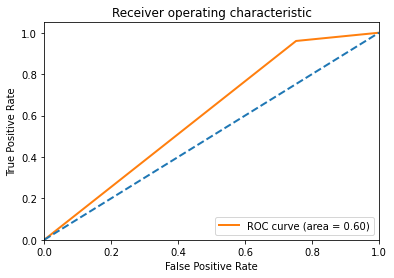

In [111]:
#Scaled -Balancing through SMote
Lclf_pca_SMOTE = LogisticClassifier(Xtrain_pca, Xvalidate_pca, Xtest_pca, ytrain_pca, yvalidate_pca, ytest_pca , balancing="SMOTE")

------------------------------------------------------------
Initializing Logitic Regression Classifier
------------------------------------------------------------
Preprocessing in progress...
------------------------------------------------------------
Performing Grid Search...
Best base params after grid search {'class_weight': 'balanced', 'max_iter': 100, 'solver': 'saga'}
Best base estimators after grid search LogisticRegression(class_weight='balanced', n_jobs=-1, solver='saga')
Best params after grid search {'C': 1000.0, 'penalty': 'l1'}


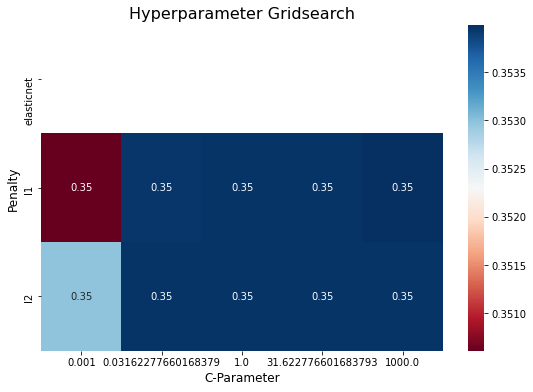

------------------------------------------------------------
------------------------------------------------------------
Predicting...
------------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

    Regulars       0.95      0.75      0.84    103530
        Hits       0.24      0.68      0.35     11593

    accuracy                           0.75    115123
   macro avg       0.60      0.72      0.60    115123
weighted avg       0.88      0.75      0.79    115123

TN: 78117
FP: 25413
FN: 3719
TP: 7874


------------------------------------------------------------
Coefficients
+---------------------+---------------------+---------------------+---------------------+--------------------+-------------------+----------------------+---------------------+---------------------+-----------------------+---------------------+---------------------+-----------------------+---------------------+---------------------+---------------------+---------------------+
|          0          |          1          |          2          |          3          |         4          |         5         |          6           |          7          |          8          |           9           |          10         |          11         |           12          |          13         |          14         |          15         |      intercept      |
+---------------------+---------------------+---------------------+---------------------+--------------------+-------------------+----------------------+-----------------

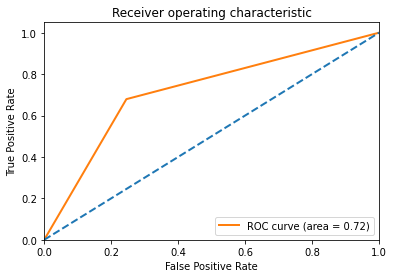

In [112]:
#Unscaled Balancing through wheighting
Lclf_pca_us = LogisticClassifier(Xtrain_pca, Xvalidate_pca, Xtest_pca, ytrain_pca, yvalidate_pca, ytest_pca , scale = False)

------------------------------------------------------------
Initializing Logitic Regression Classifier
------------------------------------------------------------
Preprocessing in progress...
------------------------------------------------------------
Performing Grid Search...
Best base params after grid search {'class_weight': None, 'max_iter': 100, 'solver': 'liblinear'}
Best base estimators after grid search LogisticRegression(n_jobs=-1, solver='liblinear')
Best params after grid search {'C': 1.0, 'penalty': 'l1'}


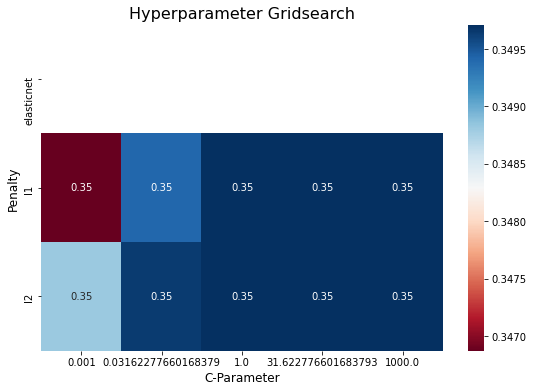

------------------------------------------------------------
------------------------------------------------------------
Predicting...
------------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

    Regulars       0.95      0.83      0.88    103530
        Hits       0.27      0.59      0.37     11593

    accuracy                           0.80    115123
   macro avg       0.61      0.71      0.63    115123
weighted avg       0.88      0.80      0.83    115123

TN: 85424
FP: 18106
FN: 4790
TP: 6803


------------------------------------------------------------
Coefficients
+----------------------+--------------------+----------------------+----------------------+--------------------+--------------------+----------------------+----------------------+---------------------+----------------------+---------------------+---------------------+----------------------+---------------------+---------------------+---------------------+---------------------+
|          0           |         1          |          2           |          3           |         4          |         5          |          6           |          7           |          8          |          9           |          10         |          11         |          12          |          13         |          14         |          15         |      intercept      |
+----------------------+--------------------+----------------------+----------------------+--------------------+--------------------+----------------------+----------

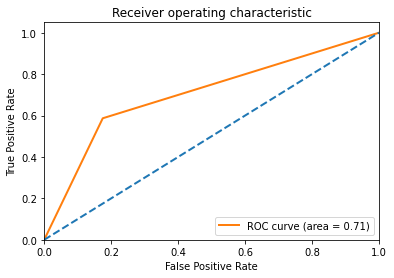

In [113]:
#Unscaled Balancing through SMOTE

Lclf_pca_us_SMOTE = LogisticClassifier(Xtrain_pca, Xvalidate_pca, Xtest_pca, ytrain_pca, yvalidate_pca, ytest_pca, scale = False, balancing="SMOTE")

------------------------------------------------------------
Initializing Logitic Regression Classifier
------------------------------------------------------------
Preprocessing in progress...
------------------------------------------------------------
Performing Grid Search...
Best base params after grid search {'class_weight': 'balanced', 'max_iter': 100, 'solver': 'saga'}
Best base estimators after grid search LogisticRegression(class_weight='balanced', n_jobs=-1, solver='saga')
Best params after grid search {'C': 1000.0, 'penalty': 'l2'}


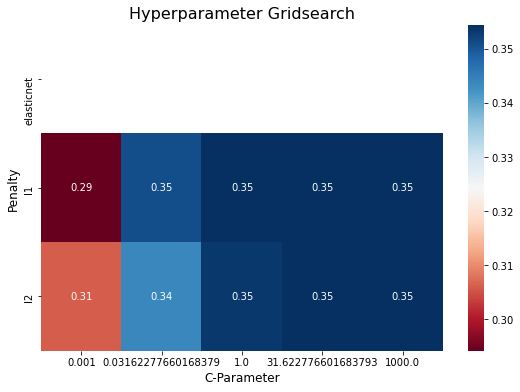

------------------------------------------------------------
------------------------------------------------------------
Predicting...
------------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

    Regulars       0.99      0.20      0.34    103530
        Hits       0.12      0.98      0.21     11593

    accuracy                           0.28    115123
   macro avg       0.55      0.59      0.28    115123
weighted avg       0.90      0.28      0.32    115123

TN: 20918
FP: 82612
FN: 270
TP: 11323


------------------------------------------------------------
Coefficients
+-------------------+--------------------+---------------------+--------------------+-------------------+-------------------+--------------------+--------------------+--------------------+---------------------+--------------------+--------------------+---------------------+--------------------+---------------------+--------------------+---------------------+
|         0         |         1          |          2          |         3          |         4         |         5         |         6          |         7          |         8          |          9          |         10         |         11         |          12         |         13         |          14         |         15         |      intercept      |
+-------------------+--------------------+---------------------+--------------------+-------------------+-------------------+--------------------+--------------------+--------------------+----------------

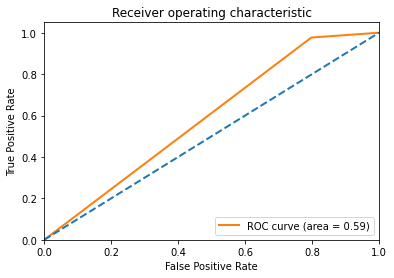

In [114]:
Xtrain_pca_or = OutlierDetection.remove_outliers(Xtrain_pca.reset_index(drop=True),global_outlier_index)

ytrain_or_pca = np.delete(ytrain_pca, global_outlier_index) 

Lclf_pca_or = LogisticClassifier(Xtrain_pca_or, Xvalidate_pca, Xtest_pca, ytrain_or_pca, yvalidate_pca, ytest_pca )

------------------------------------------------------------
Initializing Logitic Regression Classifier
------------------------------------------------------------
Preprocessing in progress...
------------------------------------------------------------
Performing Grid Search...
Best base params after grid search {'class_weight': None, 'max_iter': 1000, 'solver': 'saga'}
Best base estimators after grid search LogisticRegression(max_iter=1000, n_jobs=-1, solver='saga')
Best params after grid search {'C': 31.622776601683793, 'penalty': 'l1'}


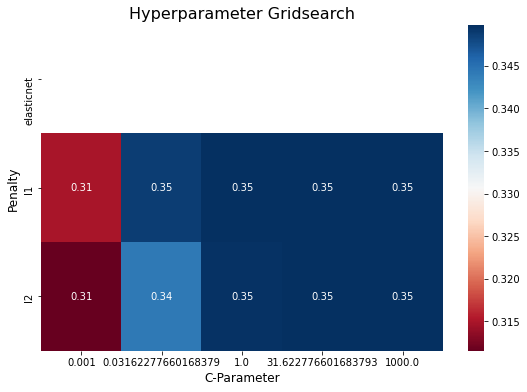

------------------------------------------------------------
------------------------------------------------------------
Predicting...
------------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

    Regulars       0.98      0.25      0.40    103530
        Hits       0.13      0.96      0.22     11593

    accuracy                           0.32    115123
   macro avg       0.55      0.61      0.31    115123
weighted avg       0.90      0.32      0.38    115123

TN: 26143
FP: 77387
FN: 473
TP: 11120


------------------------------------------------------------
Coefficients
+--------------------+--------------------+--------------------+--------------------+-------------------+-------------------+---------------------+---------------------+-------------------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|         0          |         1          |         2          |         3          |         4         |         5         |          6          |          7          |         8         |         9          |         10         |         11        |         12         |         13         |         14         |         15         |     intercept      |
+--------------------+--------------------+--------------------+--------------------+-------------------+-------------------+---------------------+---------------------+-------------------+--------------------+--

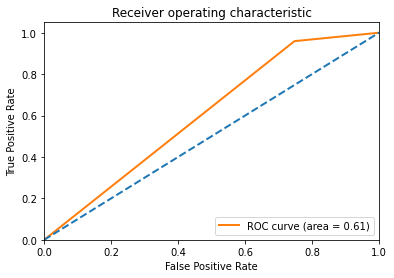

In [115]:
Lclf_pca_or_SMOTE = LogisticClassifier(Xtrain_pca_or, Xvalidate_pca, Xtest_pca, ytrain_or_pca, yvalidate_pca, ytest_pca, balancing="SMOTE")

------------------------------------------------------------
Initializing Logitic Regression Classifier
------------------------------------------------------------
Preprocessing in progress...
------------------------------------------------------------
Performing Grid Search...
Best base params after grid search {'class_weight': 'balanced', 'max_iter': 1000, 'solver': 'saga'}
Best base estimators after grid search LogisticRegression(class_weight='balanced', max_iter=1000, n_jobs=-1,
                   solver='saga')
Best params after grid search {'C': 1.0, 'penalty': 'l2'}


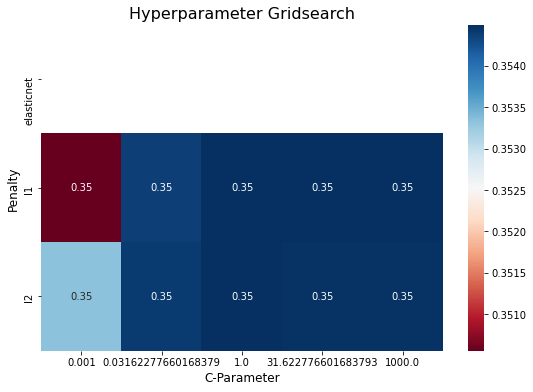

------------------------------------------------------------
------------------------------------------------------------
Predicting...
------------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

    Regulars       0.95      0.75      0.84    103530
        Hits       0.24      0.68      0.35     11593

    accuracy                           0.75    115123
   macro avg       0.60      0.72      0.60    115123
weighted avg       0.88      0.75      0.79    115123

TN: 78155
FP: 25375
FN: 3725
TP: 7868


------------------------------------------------------------
Coefficients
+---------------------+--------------------+----------------------+---------------------+--------------------+--------------------+----------------------+---------------------+---------------------+----------------------+---------------------+---------------------+-----------------------+----------------------+---------------------+---------------------+---------------------+
|          0          |         1          |          2           |          3          |         4          |         5          |          6           |          7          |          8          |          9           |          10         |          11         |           12          |          13          |          14         |          15         |      intercept      |
+---------------------+--------------------+----------------------+---------------------+--------------------+--------------------+----------------------+--------------

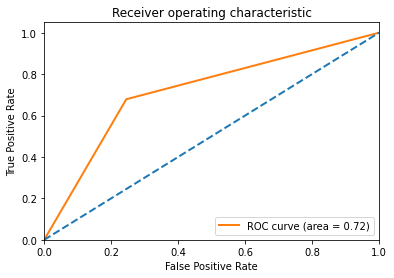

In [116]:
Lclf_pca_or_us = LogisticClassifier(Xtrain_pca_or, Xvalidate_pca, Xtest_pca, ytrain_or_pca, yvalidate_pca, ytest_pca, scale= False)

------------------------------------------------------------
Initializing Logitic Regression Classifier
------------------------------------------------------------
Preprocessing in progress...
------------------------------------------------------------
Performing Grid Search...
Best base params after grid search {'class_weight': None, 'max_iter': 100, 'solver': 'liblinear'}
Best base estimators after grid search LogisticRegression(n_jobs=-1, solver='liblinear')
Best params after grid search {'C': 1000.0, 'penalty': 'l1'}


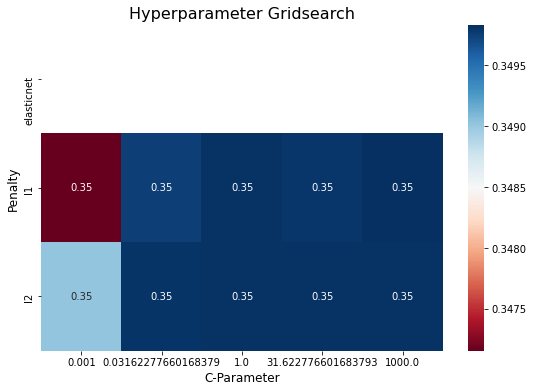

------------------------------------------------------------
------------------------------------------------------------
Predicting...
------------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

    Regulars       0.95      0.83      0.88    103530
        Hits       0.27      0.59      0.37     11593

    accuracy                           0.80    115123
   macro avg       0.61      0.71      0.63    115123
weighted avg       0.88      0.80      0.83    115123

TN: 85589
FP: 17941
FN: 4809
TP: 6784


------------------------------------------------------------
Coefficients
+--------------------+---------------------+----------------------+----------------------+-------------------+--------------------+----------------------+----------------------+---------------------+---------------------+---------------------+--------------------+----------------------+---------------------+----------------------+---------------------+---------------------+
|         0          |          1          |          2           |          3           |         4         |         5          |          6           |          7           |          8          |          9          |          10         |         11         |          12          |          13         |          14          |          15         |      intercept      |
+--------------------+---------------------+----------------------+----------------------+-------------------+--------------------+----------------------+------------------

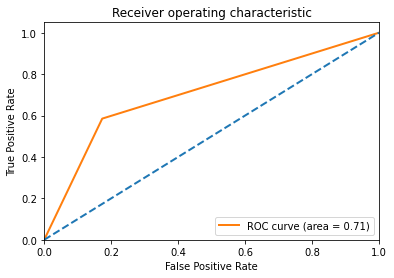

In [117]:
Lclf_pca_or_us_SMOTE = LogisticClassifier(Xtrain_pca_or, Xvalidate_pca, Xtest_pca, ytrain_or_pca, yvalidate_pca, ytest_pca, balancing="SMOTE" , scale= False)

### Performance Overview

In [118]:
def performance_overview(model_list,model_name):
    columns = []
    report_fm= model_list[0].get_classification_report()

    counter = 0
    for sup_key in report_fm.keys():
        counter += 1

        if sup_key == 'accuracy':
            columns.append(sup_key)
        else:    
            for key in report_fm[sup_key].keys():
                if counter < 6:
                    var = sup_key +"_"+key
                    columns.append(var)
                else:
                    columns.append(key)

    df_overview = pd.DataFrame(columns = columns)


    for model, name in zip(model_list,model_name):
        report = model.get_classification_report()
        values = []
        for sup_key in report.keys():

            if sup_key == 'accuracy':
                values.append(report[sup_key])
            else:
                for key in report[sup_key].keys():

                    values.append(report[sup_key][key])
        
        overview_row = pd.Series(values, index=columns, name= name)
        df_overview= df_overview.append(overview_row)
    
    return df_overview

model_list =  [Lclf,Lclf_us,Lclf_SMOTE,Lclf_us_SMOTE, Lclf_or, Lclf_or_SMOTE, Lclf_or_us, Lclf_or_us_SMOTE, Lclf_pca, Lclf_pca_SMOTE, Lclf_pca_us, Lclf_pca_us_SMOTE,Lclf_pca_or,Lclf_pca_or_SMOTE,Lclf_pca_or_us,Lclf_pca_or_us_SMOTE]
model_name = ['Lclf','Lclf_us','Lclf_SMOTE','Lclf_us_SMOTE', 'Lclf_or', 'Lclf_or_SMOTE', 'Lclf_or_us', 'Lclf_or_us_SMOTE', 'Lclf_pca', 'Lclf_pca_SMOTE', 'Lclf_pca_us', 'Lclf_pca_us_SMOTE',"Lclf_pca_or","Lclf_pca_or_SMOTE","Lclf_pca_or_us","Lclf_pca_or_us_SMOTE"]

performance_all = performance_overview(model_list,model_name)
performance_all.to_csv('Csv/Lclf_performance.csv')

In [119]:
performance_all.sort_values('AUC', ascending = False)

,Regulars_precision,Regulars_recall,Regulars_f1-score,Regulars_support,Hits_precision,Hits_recall,Hits_f1-score,Hits_support,accuracy,macro avg_precision,...,macro avg_support,weighted avg_precision,weighted avg_recall,weighted avg_f1-score,weighted avg_support,TN,FP,FN,TP,AUC
Lclf_or,0.958045,0.755231,0.844633,103285.0,0.249889,0.711438,0.369865,11838.0,0.750727,0.603967,...,115123.0,0.885226,0.750727,0.795813,115123.0,8422.0,25281.0,3416.0,8422.0,0.733334
Lclf,0.957971,0.756063,0.845125,103285.0,0.250305,0.710593,0.370206,11838.0,0.751388,0.604138,...,115123.0,0.885203,0.751388,0.796290,115123.0,8412.0,25195.0,3426.0,8412.0,0.733328
Lclf_us,0.957389,0.760285,0.847528,103285.0,0.252039,0.704764,0.371295,11838.0,0.754576,0.604714,...,115123.0,0.884858,0.754576,0.798557,115123.0,8343.0,24759.0,3495.0,8343.0,0.732524
Lclf_pca_us,0.954555,0.754535,0.842841,103530.0,0.236549,0.679203,0.350891,11593.0,0.746949,0.595552,...,115123.0,0.882251,0.746949,0.793301,115123.0,7874.0,25413.0,3719.0,7874.0,0.716869
Lclf_pca_or_us,0.954507,0.754902,0.843051,103530.0,0.236681,0.678685,0.350968,11593.0,0.747227,0.595594,...,115123.0,0.882221,0.747227,0.793497,115123.0,7868.0,25375.0,3725.0,7868.0,0.716794
Lclf_pca_us_SMOTE,0.946904,0.825113,0.881823,103530.0,0.273114,0.586820,0.372747,11593.0,0.801117,0.610009,...,115123.0,0.879053,0.801117,0.830559,115123.0,6803.0,18106.0,4790.0,6803.0,0.705967
Lclf_pca_or_us_SMOTE,0.946802,0.826707,0.882688,103530.0,0.274378,0.585181,0.373589,11593.0,0.802385,0.610590,...,115123.0,0.879088,0.802385,0.831422,115123.0,6784.0,17941.0,4809.0,6784.0,0.705944
Lclf_us_SMOTE,0.944437,0.819722,0.877671,103285.0,0.269145,0.579236,0.367520,11838.0,0.794993,0.606791,...,115123.0,0.874997,0.794993,0.825213,115123.0,6857.0,18620.0,4981.0,6857.0,0.699479
Lclf_or_us_SMOTE,0.944234,0.821475,0.878587,103285.0,0.270205,0.576702,0.367993,11838.0,0.796305,0.607219,...,115123.0,0.874924,0.796305,0.826083,115123.0,6827.0,18439.0,5011.0,6827.0,0.699088
Lclf_SMOTE,0.943030,0.814320,0.873962,103285.0,0.260536,0.570789,0.357769,11838.0,0.789278,0.601783,...,115123.0,0.872850,0.789278,0.820882,115123.0,6757.0,19178.0,5081.0,6757.0,0.692554


In [120]:
performance_all.sort_values('Hits_f1-score', ascending = False)

,Regulars_precision,Regulars_recall,Regulars_f1-score,Regulars_support,Hits_precision,Hits_recall,Hits_f1-score,Hits_support,accuracy,macro avg_precision,...,macro avg_support,weighted avg_precision,weighted avg_recall,weighted avg_f1-score,weighted avg_support,TN,FP,FN,TP,AUC
Lclf_pca_or_us_SMOTE,0.946802,0.826707,0.882688,103530.0,0.274378,0.585181,0.373589,11593.0,0.802385,0.610590,...,115123.0,0.879088,0.802385,0.831422,115123.0,6784.0,17941.0,4809.0,6784.0,0.705944
Lclf_pca_us_SMOTE,0.946904,0.825113,0.881823,103530.0,0.273114,0.586820,0.372747,11593.0,0.801117,0.610009,...,115123.0,0.879053,0.801117,0.830559,115123.0,6803.0,18106.0,4790.0,6803.0,0.705967
Lclf_us,0.957389,0.760285,0.847528,103285.0,0.252039,0.704764,0.371295,11838.0,0.754576,0.604714,...,115123.0,0.884858,0.754576,0.798557,115123.0,8343.0,24759.0,3495.0,8343.0,0.732524
Lclf,0.957971,0.756063,0.845125,103285.0,0.250305,0.710593,0.370206,11838.0,0.751388,0.604138,...,115123.0,0.885203,0.751388,0.796290,115123.0,8412.0,25195.0,3426.0,8412.0,0.733328
Lclf_or,0.958045,0.755231,0.844633,103285.0,0.249889,0.711438,0.369865,11838.0,0.750727,0.603967,...,115123.0,0.885226,0.750727,0.795813,115123.0,8422.0,25281.0,3416.0,8422.0,0.733334
Lclf_or_us_SMOTE,0.944234,0.821475,0.878587,103285.0,0.270205,0.576702,0.367993,11838.0,0.796305,0.607219,...,115123.0,0.874924,0.796305,0.826083,115123.0,6827.0,18439.0,5011.0,6827.0,0.699088
Lclf_us_SMOTE,0.944437,0.819722,0.877671,103285.0,0.269145,0.579236,0.367520,11838.0,0.794993,0.606791,...,115123.0,0.874997,0.794993,0.825213,115123.0,6857.0,18620.0,4981.0,6857.0,0.699479
Lclf_SMOTE,0.943030,0.814320,0.873962,103285.0,0.260536,0.570789,0.357769,11838.0,0.789278,0.601783,...,115123.0,0.872850,0.789278,0.820882,115123.0,6757.0,19178.0,5081.0,6757.0,0.692554
Lclf_or_SMOTE,0.942705,0.816111,0.874852,103285.0,0.261203,0.567241,0.357695,11838.0,0.790520,0.601954,...,115123.0,0.872627,0.790520,0.821673,115123.0,6715.0,18993.0,5123.0,6715.0,0.691676
Lclf_pca_or_us,0.954507,0.754902,0.843051,103530.0,0.236681,0.678685,0.350968,11593.0,0.747227,0.595594,...,115123.0,0.882221,0.747227,0.793497,115123.0,7868.0,25375.0,3725.0,7868.0,0.716794


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=efdb1931-d19c-4850-b12b-726a7087f8c0' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>